In [1]:
import pandas
import numpy
import h5py
from helpers import plotting

from matplotlib import pyplot as plt

# FILL IN PATH TO THE FILE GENERATED BY "Test Proofreading status" HERE
fn = "save/microns1181_results.h5"


def read_all_instances(fn, key):
    with h5py.File(fn, "r") as h5:
        idxx = list(h5[key].keys())
    return [pandas.read_hdf(fn, key="{0}/{1}".format(key, i)) for i in idxx]


cols_tl = {
    "empty": "orange",
    "Non-proofread": "orange",
    "f": "red",
    "t": "green",
    "Proofread": "green"
}

## Test proofreading impact on simplex participation

We found unexpectedly many high-dimensional simplices in the Microns connectome. 
Is that result artificial due to reconstruction or segmentation errors? To answer this, we explore the following

_Question_: Are neurons that have been proofread more or less likely to participate in simplices?

If they are less likely to participate in simplices, then simplex membership is artificial.

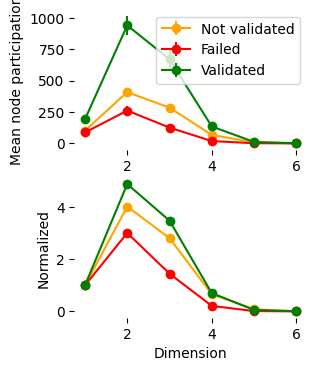

In [3]:
# READ DATA: NODE PARTICIPATION OF ALL NEURONS AND THEIR PROOFREADING STATUS
# Configure: Proofreading of which neurite type serves as the basis? Does not matter much as proofreading of dendrites and axon overlap strongly.
neurite_proofread = "axon"
str_status = dict([("dend", "status_dendrite"), ("axon", "status_axon")])[neurite_proofread]

dfs = read_all_instances(fn, "smpl_counts_vld_{0}".format(neurite_proofread))
df = pandas.concat(dfs, axis=0, keys=range(len(dfs)), names=["Instance"])

# CALCULATE MEAN
node_part_mn = df.groupby(str_status).mean()
node_part_sem = df.groupby(str_status).std() / numpy.sqrt(len(dfs))


fig = plt.figure(figsize=(3., 4))
ax = fig.add_subplot(2, 1, 1)
legend_tl = {"empty": "Not validated", "f": "Failed", "t": "Validated"}

# PLOT ABSOLUTE NUMBERS
for ix in node_part_mn.index:
    ax.errorbar(node_part_mn.columns, node_part_mn.loc[ix], yerr=node_part_sem.loc[ix],
                marker="o", label=legend_tl[ix], color=cols_tl[ix])
ax.set_ylabel("Mean node participation")
ax.set_frame_on(False)
plt.legend()

# NORMALIZED TO 1-D COUNT, I.E. REGULAR DEGREE.
ax = fig.add_subplot(2, 1, 2)
for ix in node_part_mn.index:
    ax.plot(node_part_mn.loc[ix] / node_part_mn.loc[ix][1], label=legend_tl[ix], marker='o', color=cols_tl[ix])
ax.set_ylabel("Normalized")
ax.set_xlabel("Dimension")
ax.set_frame_on(False)


### Test impact on number of unique nodes in individual positions
We found that the source position of simplices have a lower number of unique nodes than the sink position.
Is that result artificial?
To answer, we test the following

_Question_: What fractions of proofread and non-proofread neurons are participating in a simplex in each position?

Based on the result described above, we know that a lower number participates in source than sink positions. If the result is not artificial, then this trend should be as strong or stronger for proofread than for non-proofread neurons.

Note that in the main figure we show number of unique neurons divided by number of simplices, while here we show number of unique neurons divided by total number of neurons, split by proofreading status. This is required because it is neurons that are proofread, not simplices, hence a simplex can contain a mixture of proofread or non-proofread neurons. 

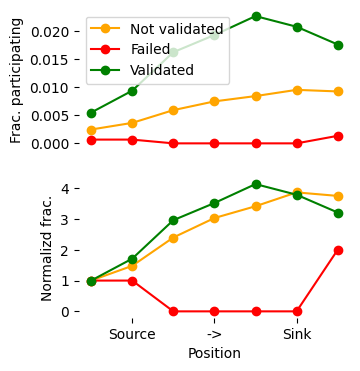

In [4]:
dfs = read_all_instances(fn, "prob_participation_in_position")
df = pandas.concat(dfs, axis=0)
prob_per_pos = df.groupby("status_axon")[[0, 1, 2, 3, 4, 5, 6]].mean()


fig = plt.figure(figsize=(3.5, 4))
ax = fig.add_subplot(2, 1, 1)
legend_tl = {"empty": "Not validated", "f": "Failed", "t": "Validated"}

# ABSOLUTE NUMBERS
for ix in prob_per_pos.index:
    ax.plot(prob_per_pos.loc[ix], label=legend_tl[ix], marker='o', color=cols_tl[ix])
ax.set_ylabel("Frac. participating")
ax.set_frame_on(False)
ax.set_xticks([])
plt.legend()

# NORMALIZED
ax = fig.add_subplot(2, 1, 2)
for ix in prob_per_pos.index:
    ax.plot(prob_per_pos.loc[ix] / prob_per_pos.loc[ix][0], label=legend_tl[ix], marker='o', color=cols_tl[ix])
ax.set_ylabel("Normalizd frac.")
ax.set_xticks([1, 3, 5]); ax.set_xticklabels(["Source", "->", "Sink"])
ax.set_xlabel("Position")
ax.set_frame_on(False)


## Test of proofreading on connectivity between inhibitory neurons and simplices

We found that inhibitory neurons are more strongly innervated by source neurons in simplices, and innervate more strongly the sink neurons.
Again, we ask: Is this result artificial?

To test this, we simply show the degree to / from proofread and non-proofread inhibitory neurons separately

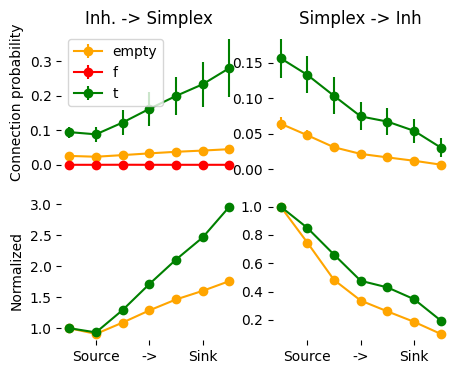

In [200]:
dfs = read_all_instances(fn, "inh_interactions_by_proofread")
df = pandas.concat(dfs, axis=0)

# CALCULATE MEAN
degs_mn = df.mean(axis=0).unstack("Position")
degs_sem = (df.std(axis=0) / numpy.sqrt(len(dfs))).unstack("Position")

ttl_tl = {
    "Inh-to-smpl": "Inh. -> Simplex",
    "Smpl-to-inh": "Simplex -> Inh"
}

fig = plt.figure(figsize=(5., 4))
i = 1
for i, direction in enumerate(["Inh-to-smpl", "Smpl-to-inh"]):
    degs_mn_u = degs_mn.loc[direction]
    degs_sem_u = degs_sem.loc[direction]
    
    # PLOT ABSOLUTE NUMBERS
    ax = fig.add_subplot(2, 2, i + 1)
    for ix in degs_mn_u.index:
        ax.errorbar(degs_mn_u.columns, degs_mn_u.loc[ix], yerr=degs_sem_u.loc[ix],
                    marker="o", label=ix, color=cols_tl[ix])
    ax.set_ylabel("")
    ax.set_frame_on(False)
    ax.set_xticks([])
    if i == 0:
        plt.legend()
        ax.set_ylabel("Connection probability")
    ax.set_title(ttl_tl[direction])
    
    # NORMALIZED 
    ax = fig.add_subplot(2, 2, i + 3)
    for ix in degs_mn_u.index:
        ax.plot(degs_mn_u.columns, degs_mn_u.loc[ix] / degs_mn_u.loc[ix][0],
                    marker="o", label=ix, color=cols_tl[ix])
    ax.set_ylabel("")
    ax.set_frame_on(False)
    if i == 0:
        ax.set_ylabel("Normalized")
    ax.set_xticks([1, 3, 5]); ax.set_xticklabels(["Source", "->", "Sink"])


## Different classes of inhibitory neurons

We briefly explore how this specific innervation differs for different classes of inhibitor neurons.

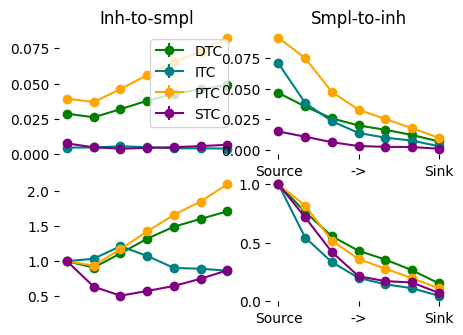

In [227]:
dfs = read_all_instances(fn, "inh_interactions_by_cell_type")
df = pandas.concat(dfs, axis=0)

mn_df = df.mean().unstack(["direction", "Position"])
sd_df = df.std().unstack(["direction", "Position"]) / numpy.sqrt(len(df))
overall_mns = df.stack(-1).mean().unstack("direction")


fig = plt.figure(figsize=(5, 3.5))
cols = ["green", "teal", "orange", "purple"]
offset = [0,0,0,0]
col_names = ("Inh-to-smpl", "Smpl-to-inh")

for i, col_nm in enumerate(col_names):
    ax = fig.add_subplot(2, 2, i+1)
    for ix, col, o in zip(mn_df.index, cols, offset):
        mn = mn_df[col_nm].loc[ix]; sd = sd_df[col_nm].loc[ix]
        x = numpy.linspace(0, 1, len(mn)) + o
        ax.errorbar(x, mn, yerr=sd, color=col, marker='o', label=ix)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_title(col_nm)
    if i == 0:
        plt.legend()
    else:
        ax.set_xticks([0, 0.5, 1]); ax.set_xticklabels(["Source", "->", "Sink"])

for i, col_nm in enumerate(col_names):
    ax = fig.add_subplot(2, 2, i+3)
    for ix, col, o in zip(mn_df.index, cols, offset):
        mn = mn_df[col_nm].loc[ix]; sd = sd_df[col_nm].loc[ix]
        x = numpy.linspace(0, 1, len(mn)) + o
        ax.plot(x, mn / mn[0], color=col, marker='o', label=ix)
    ax.set_frame_on(False)
    ax.set_xticks([])
    if i > 0:
        ax.set_xticks([0, 0.5, 1]); ax.set_xticklabels(["Source", "->", "Sink"])


Text(0, 0.5, 'Conn. prob. from simpl.')

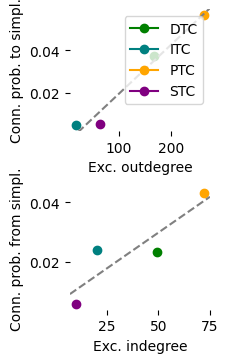

In [230]:
dfs = read_all_instances(fn, "e_degrees_by_inh_class")
# Note: The 'count' entry will be the same for all dfs, since we always 
# consider the entire inhibitory population in the connectome, independent of the excitatory subvolume chosen.
df = pandas.concat(dfs, axis=0)
degs = df.groupby(["cell_type"])[["e_indeg", "e_outdeg"]].mean()


fig = plt.figure(figsize=(1.75, 3.25))

ax = fig.add_axes([0.1, 0.6, 0.8, 0.375])
x = degs["e_outdeg"]
y = overall_mns["Inh-to-smpl"]
for ix, col in zip(x.index, cols):
    ax.plot(x[ix], y[ix], marker="o", color=col, label=ix) 
pf = numpy.polyfit(x.values, y.values, 1)
ax.set_xlim(ax.get_xlim()); ax.set_ylim(ax.get_ylim())
xlim = numpy.array(list(ax.get_xlim()))
ax.plot(xlim, pf[1] + pf[0] * xlim, ls="--", color="grey")
ax.set_frame_on(False)
ax.set_xlabel("Exc. outdegree")
ax.set_ylabel("Conn. prob. to simpl.")
plt.legend()

ax = fig.add_axes([0.1, 0.05, 0.8, 0.375])
x = degs["e_indeg"]
y = overall_mns["Smpl-to-inh"]
for ix, col in zip(x.index, cols):
    ax.plot(x[ix], y[ix], marker="o", color=col) 
pf = numpy.polyfit(x.values, y.values, 1)
ax.set_xlim(ax.get_xlim()); ax.set_ylim(ax.get_ylim())
xlim = numpy.array(list(ax.get_xlim()))
ax.plot(xlim, pf[1] + pf[0] * xlim, ls="--", color="grey")
#ax.plot(xlim, (y/x).mean() * xlim, ls="--", color="grey")
ax.set_frame_on(False)
ax.set_xlabel("Exc. indegree")
ax.set_ylabel("Conn. prob. from simpl.")

In [203]:
dfs = read_all_instances(fn, "inh_validation_stats")
df = dfs[0]
for _df in dfs[1:]: df = df.add(_df)
df["status_dendrite"] / df["count"]

cell_type
PTC    0.026786
DTC    0.024483
ITC    0.018813
STC    0.013769
dtype: float64